In [2]:
import pandas as pd 
import json 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sentence_transformers import SentenceTransformer
import jsonlines
import umap


In [3]:
model = SentenceTransformer('all-mpnet-base-v2')


/u/trevahok/.conda/envs/venv/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [4]:
data = {}
with jsonlines.open('convo_history.jsonl') as f:
    data = list(f)


In [5]:
data[0].keys()

dict_keys(['id', 'created_at', 'convo', 'convo_id', 'course_name', 'user_email'])

In [6]:
def print_messages(data):
    convo_id = data.get('id', 'Unknown ID')
    messages = data.get('convo', {}).get('messages', [])
    print(f"id: {convo_id}")
    for message in messages[:1]:
        role = message.get('role', 'Unknown role').title()
        content = message.get('content', 'No content')

        # print(f"{role}: {content[:50]}...")
        print(f"{role}: {content}...")



In [63]:
def get_first_query(data):
    messages = data['convo']['messages']
    message = messages[0]
    content = message.get('content', None)
    if isinstance(content, list) : 
        return ','.join( i['text'] for i in content ) 
    return content
    

In [8]:
def get_first_response(data):
    messages = data.get('convo', {}).get('messages', [])
    if len(messages) > 1 and messages[1] and messages[1]['role'] == 'assistant': 
        content = messages[1].get('content', None)
        return content
    return None

In [23]:
def get_first_contexts(data): 
    messages = data.get('convo', {}).get('messages', [])
    if len(messages) > 1 and messages[1] and messages[1]['role'] == 'assistant' and 'contexts' in messages[1] : 
        content = messages[1].get('contexts', {})
        return content
    return None

In [10]:
get_first_query(data[0])

'what is this course about?'

In [11]:
df = pd.DataFrame(data)

In [12]:
df.head()

,id,created_at,convo,convo_id,course_name,user_email
0,3596,2023-08-17T17:01:09.926926-07:00,"{'id': '212673d9-89cb-4243-9c9a-b5f062cb43db',...",212673d9-89cb-4243-9c9a-b5f062cb43db,ECE408FA23,kindrtnk@illinois.edu
1,3599,2023-08-17T17:05:36.003505-07:00,"{'id': 'ed614a74-150e-4c71-b013-5d7f0a8f2ccf',...",ed614a74-150e-4c71-b013-5d7f0a8f2ccf,ECE408FA23,kindrtnk@illinois.edu
2,3604,2023-08-17T17:20:56.389852-07:00,"{'id': '8f5454ee-7a6c-40f1-b069-01ae41c20fc9',...",8f5454ee-7a6c-40f1-b069-01ae41c20fc9,ECE408FA23,kindrtnk@illinois.edu
3,3610,2023-08-17T23:53:43.926244-07:00,"{'id': 'f640a5f4-a3d9-40c2-aff0-8dbf6644414c',...",f640a5f4-a3d9-40c2-aff0-8dbf6644414c,ECE408FA23,None
4,3612,2023-08-18T08:13:41.725381-07:00,"{'id': 'fa043868-9669-4af9-a97d-24f987a90d84',...",fa043868-9669-4af9-a97d-24f987a90d84,ECE408FA23,None


# Extract query, response, context 

In [64]:
df['first_query'] = df.apply(get_first_query, axis = 1)

In [14]:
df['first_response'] = df.apply(get_first_response, axis = 1)

In [15]:
df.head()

,id,created_at,convo,convo_id,course_name,user_email,first_query,first_response
0,3596,2023-08-17T17:01:09.926926-07:00,"{'id': '212673d9-89cb-4243-9c9a-b5f062cb43db',...",212673d9-89cb-4243-9c9a-b5f062cb43db,ECE408FA23,kindrtnk@illinois.edu,what is this course about?,"The course, ECE 408-Applied Parallel Programmi..."
1,3599,2023-08-17T17:05:36.003505-07:00,"{'id': 'ed614a74-150e-4c71-b013-5d7f0a8f2ccf',...",ed614a74-150e-4c71-b013-5d7f0a8f2ccf,ECE408FA23,kindrtnk@illinois.edu,What is CUDA?,"CUDA, which stands for Compute Unified Device ..."
2,3604,2023-08-17T17:20:56.389852-07:00,"{'id': '8f5454ee-7a6c-40f1-b069-01ae41c20fc9',...",8f5454ee-7a6c-40f1-b069-01ae41c20fc9,ECE408FA23,kindrtnk@illinois.edu,help me,"Sure, I'd be happy to help! Could you please p..."
3,3610,2023-08-17T23:53:43.926244-07:00,"{'id': 'f640a5f4-a3d9-40c2-aff0-8dbf6644414c',...",f640a5f4-a3d9-40c2-aff0-8dbf6644414c,ECE408FA23,None,I wonder what is a thread scheduler.,A thread scheduler is a component of the syste...
4,3612,2023-08-18T08:13:41.725381-07:00,"{'id': 'fa043868-9669-4af9-a97d-24f987a90d84',...",fa043868-9669-4af9-a97d-24f987a90d84,ECE408FA23,None,What is the learning goal,The learning goal is to understand how to prog...


In [108]:
df['first_query_embeddings'] = df['first_query'].apply(lambda query: model.encode(query))


In [109]:
df.head()

,id,created_at,convo,convo_id,course_name,user_email,first_query,first_response,first_query_embeddings,first_contexts,contexts,full_prompt
0,3596,2023-08-17T17:01:09.926926-07:00,"{'id': '212673d9-89cb-4243-9c9a-b5f062cb43db',...",212673d9-89cb-4243-9c9a-b5f062cb43db,ECE408FA23,kindrtnk@illinois.edu,what is this course about?,"The course, ECE 408-Applied Parallel Programmi...","[0.015040322, -0.05690919, -0.009083111, 0.037...","[{'base_url': '', 'course_name ': 'ECE408FA23'...",---\n1: Fall 2023-ECE 408-Applied Parallel Pro...,\nPlease analyze and respond to the following ...
1,3599,2023-08-17T17:05:36.003505-07:00,"{'id': 'ed614a74-150e-4c71-b013-5d7f0a8f2ccf',...",ed614a74-150e-4c71-b013-5d7f0a8f2ccf,ECE408FA23,kindrtnk@illinois.edu,What is CUDA?,"CUDA, which stands for Compute Unified Device ...","[-0.008685957, -0.07259277, -0.054244973, 0.02...","[{'base_url': '', 'course_name ': 'ECE408FA23'...","---\n1: CUDA_C_Best_Practices_Guide.pdf, page:...",\nPlease analyze and respond to the following ...
2,3604,2023-08-17T17:20:56.389852-07:00,"{'id': '8f5454ee-7a6c-40f1-b069-01ae41c20fc9',...",8f5454ee-7a6c-40f1-b069-01ae41c20fc9,ECE408FA23,kindrtnk@illinois.edu,help me,"Sure, I'd be happy to help! Could you please p...","[0.0011467632, -0.0058061667, 0.0054057417, 0....","[{'base_url': '', 'course_name ': 'ECE408FA23'...","---\n1: CUDA_Runtime_API.pdf, page: 17\n ........",\nPlease analyze and respond to the following ...
3,3610,2023-08-17T23:53:43.926244-07:00,"{'id': 'f640a5f4-a3d9-40c2-aff0-8dbf6644414c',...",f640a5f4-a3d9-40c2-aff0-8dbf6644414c,ECE408FA23,None,I wonder what is a thread scheduler.,A thread scheduler is a component of the syste...,"[0.004244568, -0.08677512, -0.022907391, 0.058...","[{'base_url': '', 'course_name ': 'ECE408FA23'...",---\n1: 3rd-Edition-Chapter02-data-parallel-pr...,\nPlease analyze and respond to the following ...
4,3612,2023-08-18T08:13:41.725381-07:00,"{'id': 'fa043868-9669-4af9-a97d-24f987a90d84',...",fa043868-9669-4af9-a97d-24f987a90d84,ECE408FA23,None,What is the learning goal,The learning goal is to understand how to prog...,"[0.017612156, -0.006038479, -0.008438804, 0.01...","[{'base_url': '', 'course_name ': 'ECE408FA23'...",---\n1: 3rd-Edition-Chapter16-case-study-DNN-F...,\nPlease analyze and respond to the following ...


In [24]:
df['first_contexts'] = df.apply(get_first_contexts, axis = 1)

In [25]:
df = df.dropna(subset=['first_response', 'first_contexts'] )

In [26]:
df = df[df['first_contexts'].apply(len) > 0]

In [27]:
len(df)

2040

In [28]:
df.head()

,id,created_at,convo,convo_id,course_name,user_email,first_query,first_response,first_query_embeddings,first_contexts
0,3596,2023-08-17T17:01:09.926926-07:00,"{'id': '212673d9-89cb-4243-9c9a-b5f062cb43db',...",212673d9-89cb-4243-9c9a-b5f062cb43db,ECE408FA23,kindrtnk@illinois.edu,what is this course about?,"The course, ECE 408-Applied Parallel Programmi...","[0.015040322, -0.05690919, -0.009083111, 0.037...","[{'base_url': '', 'course_name ': 'ECE408FA23'..."
1,3599,2023-08-17T17:05:36.003505-07:00,"{'id': 'ed614a74-150e-4c71-b013-5d7f0a8f2ccf',...",ed614a74-150e-4c71-b013-5d7f0a8f2ccf,ECE408FA23,kindrtnk@illinois.edu,What is CUDA?,"CUDA, which stands for Compute Unified Device ...","[-0.008685957, -0.07259277, -0.054244973, 0.02...","[{'base_url': '', 'course_name ': 'ECE408FA23'..."
2,3604,2023-08-17T17:20:56.389852-07:00,"{'id': '8f5454ee-7a6c-40f1-b069-01ae41c20fc9',...",8f5454ee-7a6c-40f1-b069-01ae41c20fc9,ECE408FA23,kindrtnk@illinois.edu,help me,"Sure, I'd be happy to help! Could you please p...","[0.0011467632, -0.0058061667, 0.0054057417, 0....","[{'base_url': '', 'course_name ': 'ECE408FA23'..."
3,3610,2023-08-17T23:53:43.926244-07:00,"{'id': 'f640a5f4-a3d9-40c2-aff0-8dbf6644414c',...",f640a5f4-a3d9-40c2-aff0-8dbf6644414c,ECE408FA23,None,I wonder what is a thread scheduler.,A thread scheduler is a component of the syste...,"[0.004244568, -0.08677512, -0.022907391, 0.058...","[{'base_url': '', 'course_name ': 'ECE408FA23'..."
4,3612,2023-08-18T08:13:41.725381-07:00,"{'id': 'fa043868-9669-4af9-a97d-24f987a90d84',...",fa043868-9669-4af9-a97d-24f987a90d84,ECE408FA23,None,What is the learning goal,The learning goal is to understand how to prog...,"[0.017612156, -0.006038479, -0.008438804, 0.01...","[{'base_url': '', 'course_name ': 'ECE408FA23'..."


# Build full context and prompt 

In [39]:
df['contexts'] = df.first_contexts.apply( 
    lambda l: '---\n' + '---\n'.join( 
        f'''{str(i + 1)}: {d['readable_filename']}, page: {d.get('pagenumber', '')}\n {d['text']}\n''' 
        for i, d in enumerate(l)
    )
)

In [40]:
df.head()

,id,created_at,convo,convo_id,course_name,user_email,first_query,first_response,first_query_embeddings,first_contexts,contexts
0,3596,2023-08-17T17:01:09.926926-07:00,"{'id': '212673d9-89cb-4243-9c9a-b5f062cb43db',...",212673d9-89cb-4243-9c9a-b5f062cb43db,ECE408FA23,kindrtnk@illinois.edu,what is this course about?,"The course, ECE 408-Applied Parallel Programmi...","[0.015040322, -0.05690919, -0.009083111, 0.037...","[{'base_url': '', 'course_name ': 'ECE408FA23'...",---\n1: Fall 2023-ECE 408-Applied Parallel Pro...
1,3599,2023-08-17T17:05:36.003505-07:00,"{'id': 'ed614a74-150e-4c71-b013-5d7f0a8f2ccf',...",ed614a74-150e-4c71-b013-5d7f0a8f2ccf,ECE408FA23,kindrtnk@illinois.edu,What is CUDA?,"CUDA, which stands for Compute Unified Device ...","[-0.008685957, -0.07259277, -0.054244973, 0.02...","[{'base_url': '', 'course_name ': 'ECE408FA23'...","---\n1: CUDA_C_Best_Practices_Guide.pdf, page:..."
2,3604,2023-08-17T17:20:56.389852-07:00,"{'id': '8f5454ee-7a6c-40f1-b069-01ae41c20fc9',...",8f5454ee-7a6c-40f1-b069-01ae41c20fc9,ECE408FA23,kindrtnk@illinois.edu,help me,"Sure, I'd be happy to help! Could you please p...","[0.0011467632, -0.0058061667, 0.0054057417, 0....","[{'base_url': '', 'course_name ': 'ECE408FA23'...","---\n1: CUDA_Runtime_API.pdf, page: 17\n ........"
3,3610,2023-08-17T23:53:43.926244-07:00,"{'id': 'f640a5f4-a3d9-40c2-aff0-8dbf6644414c',...",f640a5f4-a3d9-40c2-aff0-8dbf6644414c,ECE408FA23,None,I wonder what is a thread scheduler.,A thread scheduler is a component of the syste...,"[0.004244568, -0.08677512, -0.022907391, 0.058...","[{'base_url': '', 'course_name ': 'ECE408FA23'...",---\n1: 3rd-Edition-Chapter02-data-parallel-pr...
4,3612,2023-08-18T08:13:41.725381-07:00,"{'id': 'fa043868-9669-4af9-a97d-24f987a90d84',...",fa043868-9669-4af9-a97d-24f987a90d84,ECE408FA23,None,What is the learning goal,The learning goal is to understand how to prog...,"[0.017612156, -0.006038479, -0.008438804, 0.01...","[{'base_url': '', 'course_name ': 'ECE408FA23'...",---\n1: 3rd-Edition-Chapter16-case-study-DNN-F...


In [81]:
pre_context = '''
Please analyze and respond to the following question using the excerpts from the provided documents. These documents can be pdf files or web pages.
    Integrate relevant information from these documents, ensuring each reference is linked to the document's number.
    Your response should be semi-formal. 
    When quoting directly, cite with footnotes linked to the document number and page number, if provided. 
    Summarize or paraphrase other relevant information with inline citations, again referencing the document number and page number, if provided.
    If the answer is not in the provided documents, state so. 
    Conclude your response with a LIST of the document titles as clickable placeholders, each linked to its respective document number and page number, if provided.
    Always share page numbers if they were shared with you.
    ALWAYS follow the examples below:
    Insert an inline citation like this in your response: 
    "[1]" if you're referencing the first document or 
    "[1, page: 2]" if you're referencing page 2 of the first document.
    At the end of your response, list the document title with a clickable link, like this: 
    "1. [document_name](#)" if you're referencing the first document or
    "1. [document_name, page: 2](#)" if you're referencing page 2 of the first document.
    Nothing else should prefixxed or suffixed to the citation or document name. Consecutive citations should be separated by a comma.
    
    Suppose a document name is shared with you along with the index and pageNumber below like "27: www.pdf, page: 2", "28: www.osd", "29: pdf.www, page 11\n15" where 27, 28, 29 are indices, www.pdf, www.osd, pdf.www are document_name, and 2, 11 are the pageNumbers and 15 is the content of the document, then inline citations and final list of cited documents should ALWAYS be in the following format:
    """
    The sky is blue. [27, page: 2][28] The grass is green. [29, page: 11]
    Relevant Sources:

    27. [www.pdf, page: 2](#)
    28. [www.osd](#)
    29. [pdf.www, page: 11](#)
    """
    ONLY return the documents with relevant information and cited in the response. If there are no relevant sources, don't include the "Relevant Sources" section in response.
    Here are excerpts from the high-quality documents provided:
    \n
'''

In [82]:
post_context= '\n\nNow please respond to my query: '

In [83]:
df['full_prompt'] = df.apply( lambda row : pre_context + row['contexts'] + post_context + row['first_query'] , axis = 1 ) 

In [84]:
df[['full_prompt', 'first_response']].to_json('prompt_response.json') 

# Find token limits

In [85]:
import tiktoken
enc = tiktoken.encoding_for_model("gpt-4")


8397

In [116]:
x = np.array( df.first_query_embeddings.tolist() ) 


In [101]:
m = model.encode(df.first_query[:10])

In [117]:
set( i.shape for i in x ) 

{(768,)}

# Find the best clusterIds using Elbow Method, Silhouette Method

## Elbow Method 

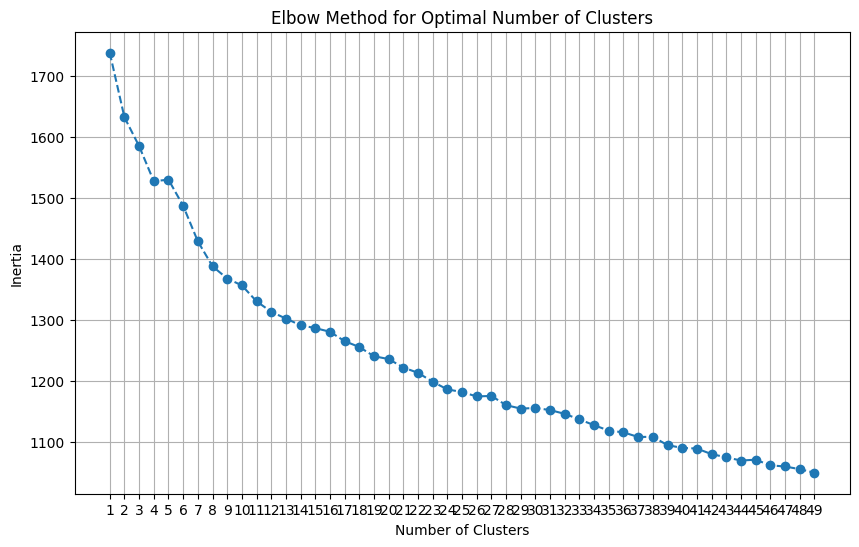

In [118]:
inertias = []
max_k = 50
x = df.first
for k in range(1, max_k):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df.first_query_embeddings.tolist())
    inertias.append(kmeans.inertia_)

# Plotting the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, max_k), inertias, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.xticks(np.arange(1, max_k, 1))
plt.grid(True)
plt.show()

## Silhouette Method

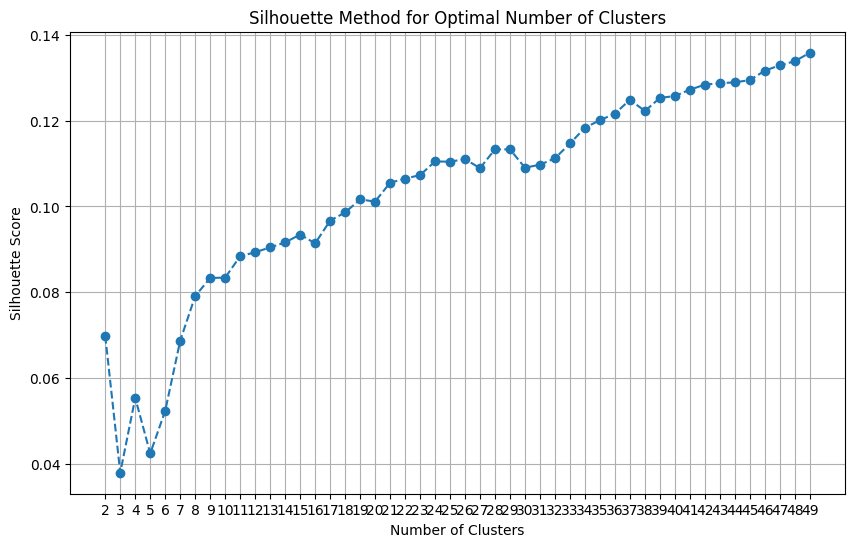

In [120]:
from sklearn.metrics import silhouette_score

# Calculate silhouette scores for different number of clusters
silhouette_scores = []
max_k = 50
embeddings = df.first_query_embeddings.tolist()
for k in range(2, max_k):
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(embeddings)
    silhouette_avg = silhouette_score(embeddings, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Find the optimal number of clusters
optimal_k = np.argmax(silhouette_scores) + 2  # +2 because we started from k=2

# Plot silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(range(2, max_k), silhouette_scores, marker='o', linestyle='--')
plt.title('Silhouette Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.xticks(np.arange(2, max_k, 1))
plt.grid(True)
plt.show()



## Fit to 23 clusters for KMeans 

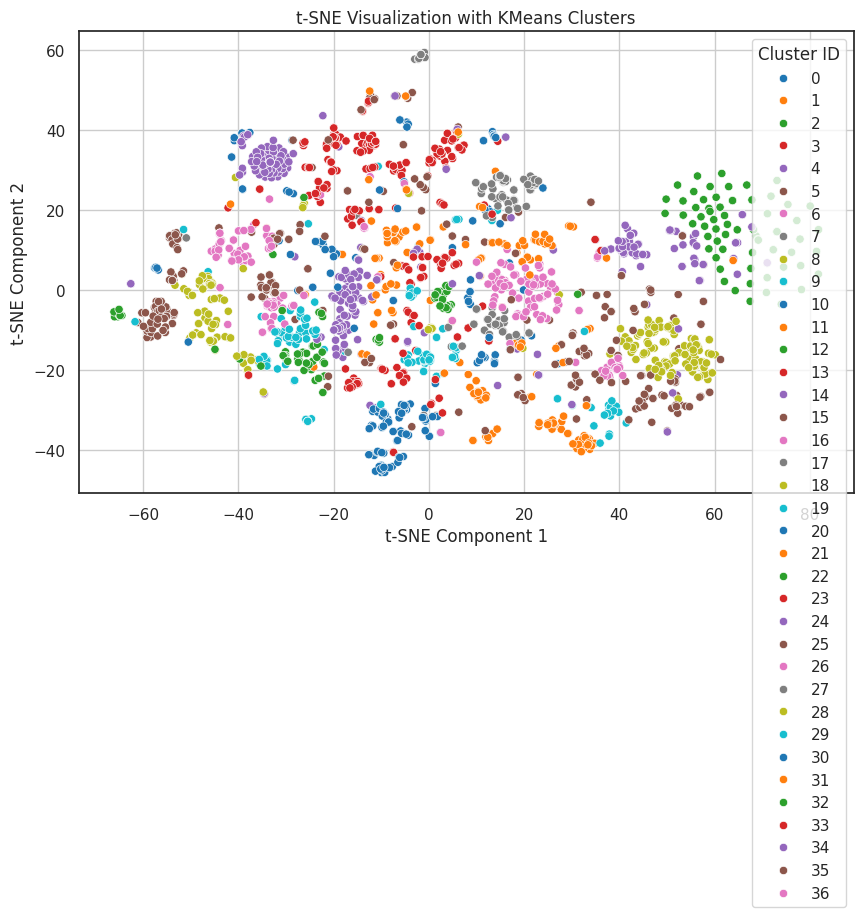

In [129]:

# Dimensionality reduction using t-SNE
tsne = TSNE(n_components=2, random_state=42)
embeddings_tsne = tsne.fit_transform(np.array(embeddings) ) 

# # Dimensionality reduction using UMAP
# umap_model = umap.UMAP(n_neighbors=5, min_dist=0.3, n_components=2, random_state=42)
# embeddings_tsne = umap_model.fit_transform(embeddings)

# # KMeans clustering
kmeans = KMeans(n_clusters=37, random_state=42)
kmeans.fit(embeddings)
cluster_ids = kmeans.labels_

# Plotting
plt.figure(figsize=(10, 6))
sns.set(style='white', palette='muted')
sns.scatterplot(x=embeddings_tsne[:, 0], y=embeddings_tsne[:, 1], hue=cluster_ids, palette='tab10', legend='full')

plt.title('t-SNE Visualization with KMeans Clusters')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='Cluster ID')
plt.grid(True)
plt.show()


# View top 6 entries for each cluster 

In [127]:
from collections import defaultdict

# Create a dictionary to store strings for each cluster
cluster_strings = defaultdict(list)

# Collect strings for each cluster
for cluster_id, string in zip(cluster_ids, df.first_query):
    cluster_strings[cluster_id].append(string)

# Display any 10 values in each cluster
for cluster_id, cluster_values in cluster_strings.items():
    print(f"Cluster {cluster_id}:")
    print(' ---' + "\n ---".join([ i[:min(100, len(i))] for i in cluster_values[:10] ]))
    print('\n\n')


Cluster 18:
 ---what is this course about?
 ---How do I succeed in this class?
 ---how to succeed in this course. 
 ---what is this course about?
 ---What code language do I need to know for thís course?
 ---How do I succeed in this class
 ---what should I prepare if I do not know how to use C and C ++
 ---hi, what is prerequisite for this course?
 ---Who teaches this class
 ---How can I succeed the class not knowing C/C++



Cluster 16:
 ---What is CUDA?
 ---I have no experience when it comes to cuda and processors. What steps should I take to succeed in th
 ---Help me with CUDA
 ---what is cuda
 ---what is cuda
 ---instruction of coding cuda code
 ---What is cuda programming
 ---what is CUDA exactly
 ---Why do GPUs not have forwarding or branch prediction?
 ---GPU



Cluster 34:
 ---help me
 ---/
 ---what is your name
 ---这门课学些什么？
 ---你好
 ---what can you do？
 ---what the fuck
 ---Who are you?
 ---Translate into Chinese:" Young termites feed on a special liquid secretion provided by a